In [1]:
import os
import sys 

current_directory = os.getcwd()
models_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(models_directory)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import seaborn as sns
import itertools

import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.lines import Line2D

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from utils.fourier_base import compute_fourier_base

from vecopsciml.operators.zero_order import Mx, My

In [3]:
from architectures.pgnniv_baseline import PGNNIVBaseline
from architectures.pgnniv_fourier import PGNNIVFourier
from architectures.pgnniv_pod import PGNNIVPOD
from architectures.pgnniv_decoder import PGNNIVAutoencoder
from architectures.autoencoder import Autoencoder

Slope (encoding, ls=100): 1.00
Slope (encoding+decoding, ls=100): 2.00


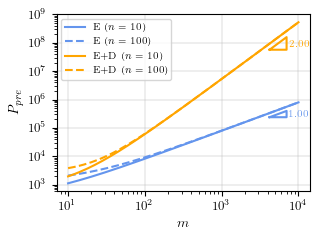

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------- Parámetros --------------------
N = np.arange(10, 10000, 2)
Nx = Ny = N // 2

# -------------------- Cálculos de Hiperparámetros --------------------
ls10 = 10
ls100 = 100

# Encoding
encoding_ls10 = 80 * (Nx + Ny) + 230 + 11 * ls10
encoding_ls100 = 80 * (Nx + Ny) + 230 + 11 * ls100

# Decoding
decoding_ls10 = 230 + 10 * ls10 + 21 * Nx * Ny
decoding_ls100 = 230 + 10 * ls100 + 21 * Nx * Ny

# Totales
total_encoding = encoding_ls100
total_encoding_decoding = encoding_ls100 + decoding_ls100

# -------------------- Cálculo de pendientes en escala log-log --------------------
logN = np.log10(N)
log_encoding = np.log10(total_encoding)
log_encoding_decoding = np.log10(total_encoding_decoding)

# Usamos los últimos 2000 puntos para calcular pendiente
slope_encoding = (log_encoding[-1] - log_encoding[-2000]) / (logN[-1] - logN[-2000])
slope_encoding_decoding = (log_encoding_decoding[-1] - log_encoding_decoding[-2000]) / (logN[-1] - logN[-2000])

print(f"Slope (encoding, ls=100): {slope_encoding:.2f}")
print(f"Slope (encoding+decoding, ls=100): {slope_encoding_decoding:.2f}")

# -------------------- Gráfico --------------------
with plt.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "figure.figsize": (3.3, 2.5),
    "axes.labelsize": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}):
    plt.figure()

    # ---- Curvas de ENCODING ----
    plt.plot(N, encoding_ls10, label=r'E ($n=10$)', color='cornflowerblue', linestyle='-')
    plt.plot(N, encoding_ls100, label=r'E ($n=100$)', color='cornflowerblue', linestyle='--')

    # Triángulo de pendiente para ENCODING
    x1, y1 = N[-2000], total_encoding[-2000]
    x2, y2 = N[-1], total_encoding[-1]
    x3 = x2
    triangle_x = [x1* 0.7, x2* 0.7, x2* 0.7, x1* 0.7]
    triangle_y = [y1 * 0.5, y2 * 0.5, y1 * 0.5, y1 * 0.5]

    x_text = x2 * 1
    y_text = y1 * 0.5

    plt.plot(triangle_x, triangle_y, color='cornflowerblue')
    plt.text(x_text, y_text, f"{slope_encoding:.2f}", ha='center', fontsize=7,
             color='cornflowerblue', fontweight='bold')

    # ---- Curvas de ENCODING + DECODING ----
    plt.plot(N, encoding_ls10 + decoding_ls10, label=r'E+D ($n=10$)', color="orange", linestyle='-')
    plt.plot(N, encoding_ls100 + decoding_ls100, label=r'E+D ($n=100$)', color="orange", linestyle='--')

    # Triángulo de pendiente para ENCODING+DECODING
    x1, y1 = N[-2000], total_encoding_decoding[-2000]
    x2, y2 = N[-1], total_encoding_decoding[-1]
    triangle_x = [x1* 0.7, x2* 0.7, x2* 0.7, x1* 0.7]
    triangle_y = [y1 * 0.3, y2 * 0.3, y1 * 0.3, y1 * 0.3]

    x_text = x2 * 1
    y_text = y1 * 0.375

    plt.plot(triangle_x, triangle_y, color='orange')
    plt.text(x_text, y_text, f"{slope_encoding_decoding:.2f}", ha='center', fontsize=7,
             color='orange', fontweight='bold')

    # ---- Configuración del gráfico ----
    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'$m$')
    plt.ylabel(r'$P_{pre}$')

    plt.legend()
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()

    plt.savefig(f'HP_evolution.pdf', bbox_inches='tight', format='pdf')
    plt.show()


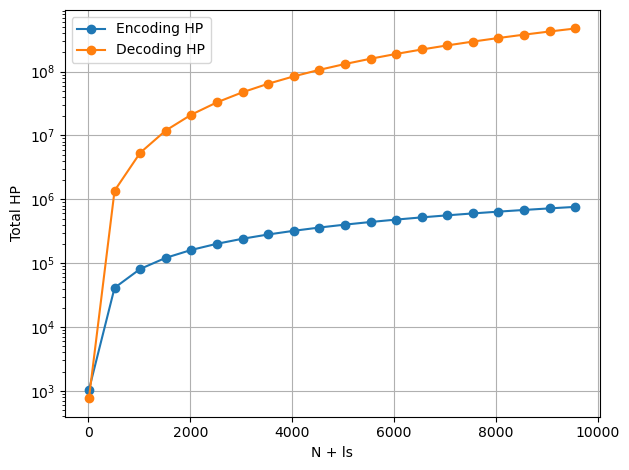

In [5]:
# Define a range of values for Nx + Ny and ls (total hyperparameters)
Nx_Ny_range = np.arange(10, 10000, 500) 
ls_values = np.linspace(1, 50, len(Nx_Ny_range)) 

# Initialize lists to store results
HP_encoding = []
HP_decoding = []
HP_total = []
HP_sum = []

# Compute HP values
for Nx_Ny, ls in zip(Nx_Ny_range, ls_values):
    Nx = Ny = Nx_Ny // 2  
    encoding = 80 * Nx_Ny + 230 + 11 * ls
    decoding = 230 + 10 * ls + 21 * Nx * Ny
    HP_encoding.append(encoding)
    HP_decoding.append(decoding)
    HP_total.append(encoding + decoding)
    HP_sum.append(Nx_Ny + ls)

# Plotting
# plt.figure(figsize=(10, 6))
plt.plot(HP_sum, HP_encoding, label="Encoding HP", marker='o')
plt.plot(HP_sum, HP_decoding, label="Decoding HP", marker='o')
plt.xlabel("N + ls")
plt.ylabel("Total HP")
# plt.title("Comparison of HP_encoding and HP_decoding evolution")
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
